# Publishing SDs, Shapefiles and CSVs

Publishing your data can be accomplished in two simple steps:
1. Add the local data as an item to the portal
2. Call the publish() method on the item

This sample notebook shows how different types of GIS datasets can be added to the GIS, and published as web layers.

In [1]:
from IPython.display import display
from arcgis.gis import GIS
import os
username = "arcgis_python"
password = "P@ssword123"
gis = GIS("https://www.arcgis.com", username, password)

In order to have the codes below run smoothly, use the pre-requisite cells as in cell[2] to delete existing .zip, .sd, or services from the `gis` content, and in cell [3] to delete existing folder.

In [2]:
def delete_existing_items(item_types, name_list):
    for current_item_type in item_types:
        for file_name in name_list:    
            search_result = gis.content.search(query=file_name, item_type=current_item_type)
            if len(search_result) > 0:
                for item in search_result:
                    item.delete()
                    print("Deleted existing " + current_item_type + ": ", item)
                    
item_types = ["Service Definition", "Feature Layer Collection", "Map Service"]
name_list = ["Nursing_home_locations", "NewPy_WTL_test_SingleLayerBuildCache"]
delete_existing_items(item_types, name_list)

item_types = ["Shapefile", "Feature Layer Collection"]
name_list = ["power_pedestals_2012"]
delete_existing_items(item_types, name_list)

item_types = ["CSV", "Feature Layer Collection"]
name_list = ["Chennai_precipitation"]
delete_existing_items(item_types, name_list)

Deleted existing Service Definition:  <Item title:"Nursing_home_locations" type:Service Definition owner:arcgis_python>
Deleted existing Service Definition:  <Item title:"NewPy_WTL_test_SingleLayerBuildCache" type:Service Definition owner:arcgis_python>
Deleted existing Feature Layer Collection:  <Item title:"Nursing_home_locations" type:Feature Layer Collection owner:arcgis_python>
Deleted existing Map Service:  <Item title:"NewPy_WTL_test_SingleLayerBuildCache" type:Map Image Layer owner:arcgis_python>
Deleted existing Shapefile:  <Item title:"power_pedestals_2012" type:Shapefile owner:arcgis_python>
Deleted existing Feature Layer Collection:  <Item title:"Locations of power pedestals collected in 2012" type:Feature Layer Collection owner:arcgis_python>
Deleted existing CSV:  <Item title:"Chennai_precipitation" type:CSV owner:arcgis_python>
Deleted existing Feature Layer Collection:  <Item title:"Chennai_precipitation" type:Feature Layer Collection owner:arcgis_python>


In [3]:
def delete_existing_folder(folder_name):
    try:
        return gis.content.delete_folder(folder=folder_name)
    except:
        return False

my_folder_name = "Rainfall Data"
delete_existing_folder(my_folder_name) # returns True if folder exists, or False if non-exist

True


# Publish all the service definition files in a folder

The sample below lists all the service definition (.sd) files in a data directory and publishes them as web layers. To publish a service definition file, we first add the .sd file to the Portal, and then call the publish() method:

In [4]:
# path relative to this notebook
data_dir = "data/"

#Get list of all files
file_list = os.listdir(data_dir)

#Filter and get only .sd files
sd_file_list = [x for x in file_list if x.endswith(".sd")]
print("Number of .sd files found: " + str(len(sd_file_list)))

Number of .sd files found: 2


<Item title:"NewPy_WTL_test_SingleLayerBuildCache" type:Map Image Layer owner:arcgis_python>

<Item title:"Nursing_home_locations" type:Feature Layer Collection owner:arcgis_python>
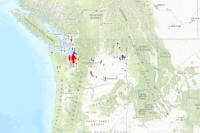

In [5]:
# Loop through each file and publish it as a service
for current_sd_file in sd_file_list:
    item = gis.content.add({}, data_dir + current_sd_file)   # .sd file is uploaded and a .sd file item is created
    if "BuildCache" not in current_sd_file:
        published_item = item.publish()                      # .sd file item is published and a web layer item is created
    else:
        published_item = item.publish(build_initial_cache=True)  # publish as hosted tile layer with "build cache" enabled
    display(published_item)

In the example shown above, one .sd file produced a web feature layer and another produced a web tile layer

# Publish a feature service from a shapefile and update the item information

To publish a shapefile, we first add the zipped shapefile to the Portal as an item, then call publish() method on the item to create a web layer. Often times, your shape files or service definitions may not contain the metadata you want to show on the portal item. This sample demonstrates how you can update those properties after publishing a web layer.

In [6]:
data = "data/power_pedestals_2012.zip"
shpfile = gis.content.add({}, data)

In [7]:
shpfile

<Item title:"power_pedestals_2012" type:Shapefile owner:arcgis_python>

In [8]:
published_service = shpfile.publish()

In [9]:
display(published_service)

<Item title:"power_pedestals_2012" type:Feature Layer Collection owner:arcgis_python>

The web layer item has minimal information and a default thumbnail.

### Update the layer item's metadata
To update the metadata and set the thumbnail, use the update() method on the web layer's item obtained during publishing.

In [10]:
thumbnail_path = "data/power_pedestals_thumbnail.PNG"
item_properties = {"snippet":"""This dataset was collected from Utah DOT open data portal.
                            Source URL: <a href="http://udot.uplan.opendata.arcgis.com/
                            datasets/a627bb128ac44767832402f7f9bde909_10">http://udot.uplan.opendata.arcgis.com/
                            datasets/a627bb128ac44767832402f7f9bde909_10</a>""",
                   "title":"Locations of power pedestals collected in 2012",
                   "tags":"opendata"}

<Item title:"Locations of power pedestals collected in 2012" type:Feature Layer Collection owner:arcgis_python>
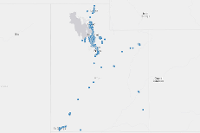

In [11]:
published_service.update(item_properties, thumbnail=thumbnail_path)
display(published_service)

# Publish a CSV file and move it into a folder

To publish a CSV file, we first add the .csv file to the Portal, and then call the publish() method to publish it as a layer. Once published, we create a destination folder on the server and then move the published items into that folder

In [12]:
csv_file = 'data/Chennai_precipitation.csv'
csv_item = gis.content.add({}, csv_file)

In [13]:
display(csv_item)

<Item title:"Chennai_precipitation" type:CSV owner:arcgis_python>

The csv file used in this sample has a column titled `LOCATION` containing place names in text. During the publishing process we specify this column as an `address_fields` parameter. The server geocodes these locations to create point features for the web layer.

In [14]:
csv_lyr = csv_item.publish(None, {"Address":"LOCATION"})

In [15]:
display(csv_lyr)

<Item title:"Chennai_precipitation" type:Feature Layer Collection owner:arcgis_python>

### Create a new folder for the items
The `create_folder()` from `GIS.content` can be used to create a new folder. Once created, the `move()` of the `Item` can be used to move the items into the folder.

In [16]:
# create a new folder called 'Rainfall Data'
new_folder_details = gis.content.create_folder(my_folder_name)
print(new_folder_details)

{'username': 'arcgis_python', 'id': 'ab08416b5850473e9439c3bf5541d07f', 'title': 'Rainfall Data'}


In [17]:
# move both the csv_item and csv_lyr items into this new folder
csv_item.move(new_folder_details)  # Here you could either pass name of the folder or the dictionary
                                   # returned from create_folder() or folders property on a User object

csv_lyr.move(new_folder_details)

{'success': True,
 'itemId': 'a6c787fa23674b90b060141b8f3cae13',
 'owner': 'arcgis_python',
 'folder': 'ab08416b5850473e9439c3bf5541d07f'}

Now that the items are moved, we can request for the item's `ownerFolder` property and ensure it matches the `id` of the folder created in the previous step

In [18]:
print(csv_lyr.ownerFolder)

ab08416b5850473e9439c3bf5541d07f
